# Commitment Analysis Across 1P2G and 2P3G Experiments

This notebook analyzes commitment patterns across different experimental conditions:

**1P2G Commitment**: Whether human's first intended goal (`player1FirstDetectedGoal`) matches their final reached goal (`player1FinalReachedGoal`)

**2P3G Commitment**: Whether the first detected shared goal (`firstDetectedSharedGoal`) matches the final reached goal

Analysis compares commitment across different RL agent types (individual vs joint).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Set publication standards
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'font.family': 'Arial'
})

# Set color palette - lightblue for individual, lightcoral for joint
colors = {'individual': 'lightblue', 'joint': 'lightcoral'}
bar_colors = ['lightblue', 'lightcoral']  # for individual and joint RL
sns.set_palette([colors['individual'], colors['joint']])

In [ ]:
# Load and prepare data
data_dir = Path('data')
excel_files = [f for f in data_dir.glob('*.xlsx') if not f.name.startswith('~$')]

def load_and_process_file(file_path):
    """Load Excel file and add metadata"""
    try:
        df = pd.read_excel(file_path)
        participant_id = file_path.name.split('_')[2]
        df = df.assign(participantID=participant_id)
        return df
    except Exception as e:
        print(f"Error loading {file_path.name}: {e}")
        return None

# Load all files
all_data = []
for file_path in excel_files:
    df = load_and_process_file(file_path)
    if df is not None:
        all_data.append(df)

# Combine all data
df = pd.concat(all_data, ignore_index=True)
print(f"Loaded {len(df)} trials from {len(excel_files)} participants")
print(f"Experiment types: {df['experimentType'].unique()}")
print(f"RL Agent types: {df['rlAgentType'].unique()}")


Loaded 2100 trials from 60 participants
Experiment types: ['1P1G' '1P2G' '2P2G' '2P3G']
RL Agent types: ['joint' 'individual']


In [ ]:
# Examine data structure for commitment analysis
print("=== Data Structure for Commitment Analysis ===")
print("\n1P2G relevant columns:")
print("- player1FirstDetectedGoal:", df[df['experimentType']=='1P2G']['player1FirstDetectedGoal'].dtype)
print("- player1FinalReachedGoal:", df[df['experimentType']=='1P2G']['player1FinalReachedGoal'].dtype)

print("\n2P3G relevant columns:")
print("- firstDetectedSharedGoal:", df[df['experimentType']=='2P3G']['firstDetectedSharedGoal'].dtype if '2P3G' in df['experimentType'].values else "No 2P3G data found")

# Check what experiment types we actually have
print("\nActual experiment types in data:")
print(df['experimentType'].value_counts())

# Check sample data
print("\nSample 1P2G data:")
sample_1p2g = df[df['experimentType']=='1P2G'].head()
for col in ['player1FirstDetectedGoal', 'player1FinalReachedGoal']:
    if col in sample_1p2g.columns:
        print(f"{col}: {sample_1p2g[col].tolist()[:5]}")

print("\nSample 2P2G data (checking for shared goal fields):")
sample_2p2g = df[df['experimentType']=='2P2G'].head()
for col in ['firstDetectedSharedGoal', 'player1FinalReachedGoal', 'player2FinalReachedGoal']:
    if col in sample_2p2g.columns:
        print(f"{col}: {sample_2p2g[col].tolist()[:5]}")


=== Data Structure for Commitment Analysis ===

1P2G relevant columns:
- player1FirstDetectedGoal: float64
- player1FinalReachedGoal: float64

2P3G relevant columns:
- firstDetectedSharedGoal: float64

Actual experiment types in data:
experimentType
1P2G    720
2P3G    720
2P2G    480
1P1G    180
Name: count, dtype: int64

Sample 1P2G data:
player1FirstDetectedGoal: [1.0, 1.0, 0.0, 1.0, 0.0]
player1FinalReachedGoal: [1.0, 1.0, 0.0, 1.0, 0.0]

Sample 2P2G data (checking for shared goal fields):
firstDetectedSharedGoal: [nan, nan, nan, nan, nan]
player1FinalReachedGoal: [1.0, 1.0, 1.0, 0.0, 1.0]
player2FinalReachedGoal: [1.0, 1.0, 1.0, 0.0, 1.0]


In [ ]:
def calculate_commitment_1p2g(row):
    """Calculate commitment for 1P2G: first detected goal == final reached goal"""
    first_goal = row['player1FirstDetectedGoal']
    final_goal = row['player1FinalReachedGoal']

    # Handle missing or null values
    if pd.isna(first_goal) or pd.isna(final_goal):
        return np.nan

    # Convert to int if possible for comparison
    try:
        first_goal = int(first_goal)
        final_goal = int(final_goal)
        return 1 if first_goal == final_goal else 0
    except (ValueError, TypeError):
        return np.nan

def calculate_commitment_2p3g(row):
    """Calculate commitment for 2P3G: first detected shared goal == final reached goal"""
    shared_goal = row.get('firstDetectedSharedGoal')
    # For 2P3G, we need to determine what the final reached goal is
    # This might be when both players reach the same goal
    final_goal_p1 = row.get('player1FinalReachedGoal')
    final_goal_p2 = row.get('player2FinalReachedGoal')

    # Handle missing values
    if pd.isna(shared_goal):
        return np.nan

    # If both players reached the same goal, that's the final goal
    if not pd.isna(final_goal_p1) and not pd.isna(final_goal_p2):
        try:
            shared_goal = int(shared_goal)
            final_goal_p1 = int(final_goal_p1)
            final_goal_p2 = int(final_goal_p2)

            # Check if they reached the same goal
            if final_goal_p1 == final_goal_p2:
                final_goal = final_goal_p1
                return 1 if shared_goal == final_goal else 0
            else:
                return 0  # No commitment if they didn't reach the same goal
        except (ValueError, TypeError):
            return np.nan

    return np.nan

# Apply commitment calculations
df_1p2g = df[df['experimentType'] == '1P2G'].copy()
df_1p2g['commitment'] = df_1p2g.apply(calculate_commitment_1p2g, axis=1)
df_1p2g['experiment_category'] = '1P2G'

# Check if we have 2P3G data, otherwise use 2P2G as proxy
if '2P3G' in df['experimentType'].values:
    df_2p3g = df[df['experimentType'] == '2P3G'].copy()
    df_2p3g['commitment'] = df_2p3g.apply(calculate_commitment_2p3g, axis=1)
    df_2p3g['experiment_category'] = '2P3G'
else:
    print("No 2P3G data found, using 2P2G as collaborative condition")
    df_2p3g = df[df['experimentType'] == '2P2G'].copy()
    df_2p3g['commitment'] = df_2p3g.apply(calculate_commitment_2p3g, axis=1)
    df_2p3g['experiment_category'] = '2P2G (Collaborative)'

# Combine data
commitment_data = pd.concat([df_1p2g, df_2p3g], ignore_index=True)

print(f"Commitment analysis prepared for {len(commitment_data)} trials")
print(f"Valid commitment scores: {commitment_data['commitment'].notna().sum()}")
print("\nCommitment by experiment type:")
print(commitment_data.groupby('experiment_category')['commitment'].agg(['count', 'mean', 'std']).round(3))


Commitment analysis prepared for 1440 trials
Valid commitment scores: 1435

Commitment by experiment type:
                     count   mean    std
experiment_category                     
1P2G                   719  0.803  0.398
2P3G                   716  0.732  0.443


In [ ]:
# Aggregate data at participant level first
print("=== Aggregating Data at Participant Level ===")
participant_commitment = commitment_data.groupby(['participantID', 'experiment_category', 'rlAgentType'])['commitment'].agg([
    'count', 'mean'
]).reset_index()
participant_commitment.columns = ['participantID', 'experiment_category', 'rlAgentType', 'n_trials', 'commitment_rate']

print(f"Participant-level data: {len(participant_commitment)} participants")
print(participant_commitment.groupby(['experiment_category', 'rlAgentType']).agg({
    'participantID': 'count',
    'commitment_rate': ['mean', 'std', 'sem'],
    'n_trials': 'mean'
}).round(3))

# Analyze commitment by RL agent type using participant-level data
commitment_by_rl_participant = participant_commitment.groupby(['experiment_category', 'rlAgentType'])['commitment_rate'].agg([
    'count', 'mean', 'std', 'sem'
]).round(3)

print("\n=== Commitment Analysis by RL Agent Type (Participant-Level) ===")
print(commitment_by_rl_participant)

# Statistical tests using participant-level data
print("\n=== Statistical Tests (Participant-Level) ===")

# Test within each experiment type
for exp_type in participant_commitment['experiment_category'].unique():
    exp_data = participant_commitment[participant_commitment['experiment_category'] == exp_type]

    individual_data = exp_data[exp_data['rlAgentType'] == 'individual']['commitment_rate'].dropna()
    joint_data = exp_data[exp_data['rlAgentType'] == 'joint']['commitment_rate'].dropna()

    if len(individual_data) > 0 and len(joint_data) > 0:
        # T-test
        t_stat, p_value = stats.ttest_ind(individual_data, joint_data)

        # Mann-Whitney U test (non-parametric)
        u_stat, u_p_value = stats.mannwhitneyu(individual_data, joint_data, alternative='two-sided')

        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(individual_data)-1)*individual_data.var() +
                             (len(joint_data)-1)*joint_data.var()) /
                            (len(individual_data) + len(joint_data) - 2))
        cohens_d = (individual_data.mean() - joint_data.mean()) / pooled_std

        print(f"\n{exp_type}:")
        print(f"  Individual RL: n={len(individual_data)}, mean={individual_data.mean():.3f} ± {individual_data.std():.3f}")
        print(f"  Joint RL: n={len(joint_data)}, mean={joint_data.mean():.3f} ± {joint_data.std():.3f}")
        print(f"  T-test: t={t_stat:.3f}, p={p_value:.3f}")
        print(f"  Mann-Whitney U: U={u_stat:.3f}, p={u_p_value:.3f}")
        print(f"  Cohen's d: {cohens_d:.3f}")
    else:
        print(f"\n{exp_type}: Insufficient data for statistical test")


=== Aggregating Data at Participant Level ===
Participant-level data: 120 participants
                                participantID commitment_rate                \
                                        count            mean    std    sem   
experiment_category rlAgentType                                               
1P2G                individual             30           0.787  0.173  0.032   
                    joint                  30           0.817  0.160  0.029   
2P3G                individual             30           0.681  0.084  0.015   
                    joint                  30           0.783  0.119  0.022   

                                n_trials  
                                    mean  
experiment_category rlAgentType           
1P2G                individual    11.967  
                    joint         12.000  
2P3G                individual    11.900  
                    joint         11.967  

=== Commitment Analysis by RL Agent Type (Participant-Lev

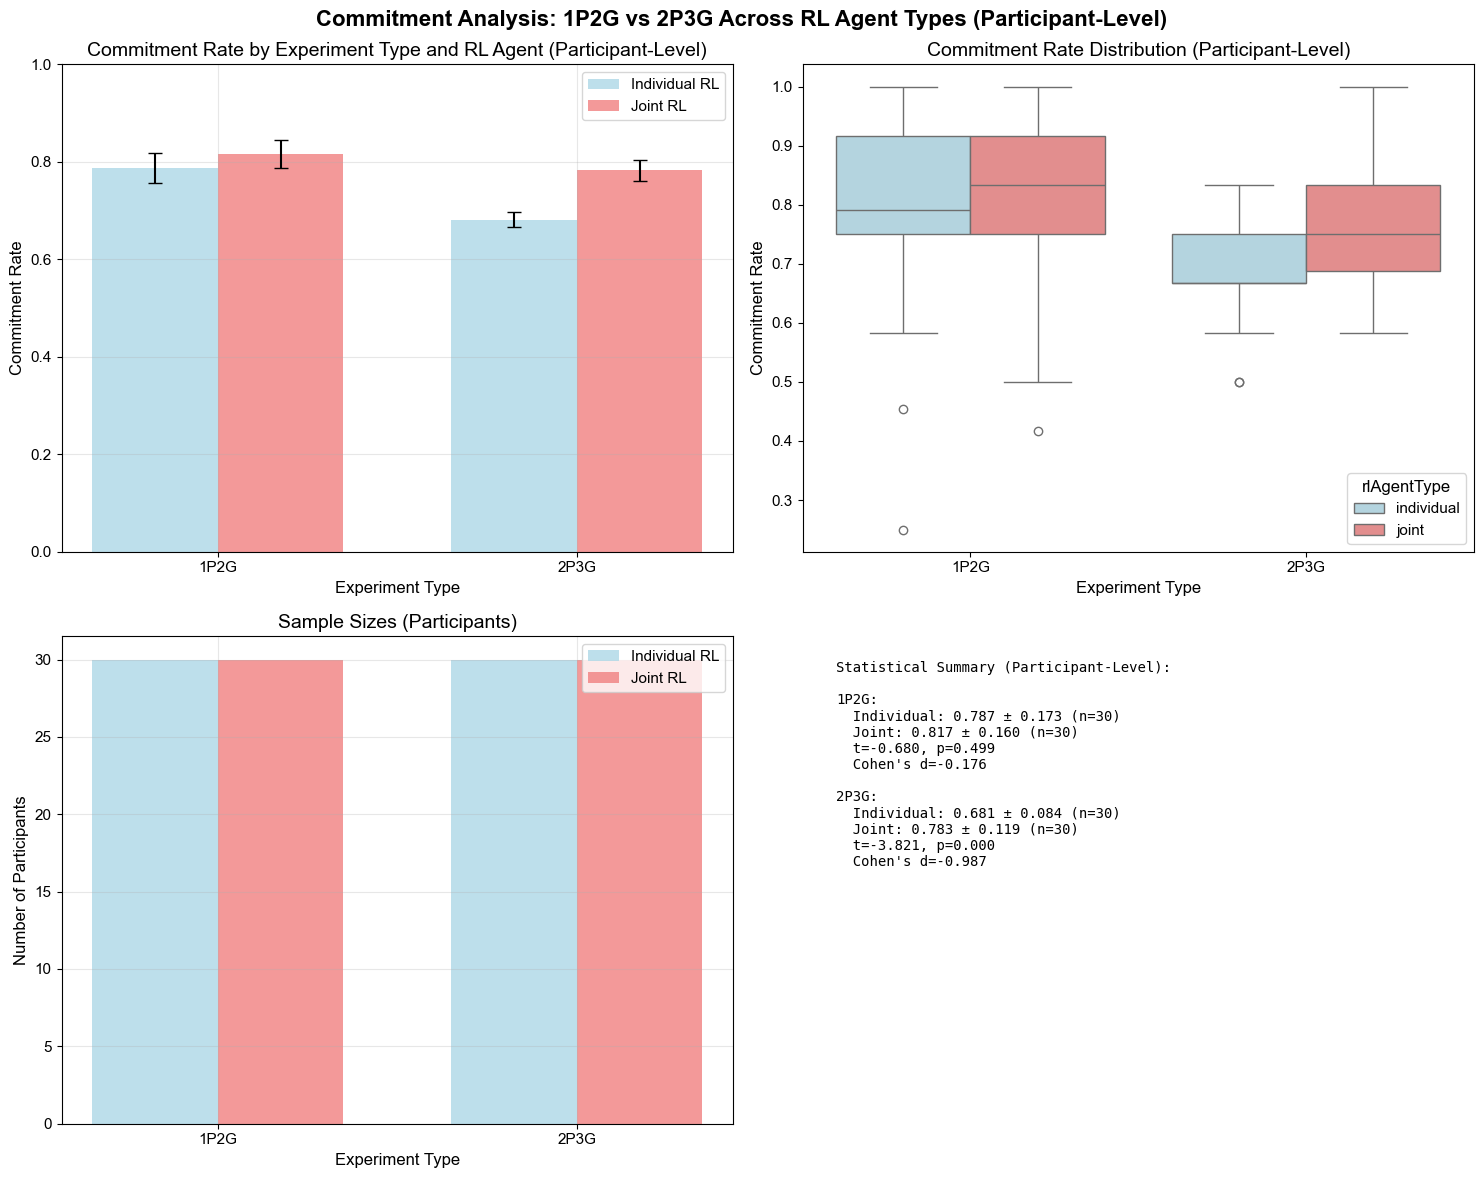

In [ ]:
# Create comprehensive visualization using participant-level data
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Commitment Analysis: 1P2G vs 2P3G Across RL Agent Types (Participant-Level)', fontsize=16, fontweight='bold')

# 1. Main comparison bar plot with participant-level error bars
ax1 = axes[0, 0]
commitment_summary_participant = participant_commitment.groupby(['experiment_category', 'rlAgentType'])['commitment_rate'].agg(['mean', 'sem']).reset_index()

x_pos = np.arange(len(commitment_summary_participant['experiment_category'].unique()))
width = 0.35

for i, rl_type in enumerate(['individual', 'joint']):
    subset = commitment_summary_participant[commitment_summary_participant['rlAgentType'] == rl_type]
    if len(subset) > 0:
        ax1.bar(x_pos + i*width, subset['mean'], width,
               yerr=subset['sem'], capsize=5,
               label=f'{rl_type.capitalize()} RL',
               color=colors[rl_type], alpha=0.8)

ax1.set_xlabel('Experiment Type')
ax1.set_ylabel('Commitment Rate')
ax1.set_title('Commitment Rate by Experiment Type and RL Agent (Participant-Level)')
ax1.set_xticks(x_pos + width/2)
ax1.set_xticklabels(commitment_summary_participant['experiment_category'].unique())
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# 2. Box plot for participant-level distribution
ax2 = axes[0, 1]
sns.boxplot(data=participant_commitment,
           x='experiment_category', y='commitment_rate', hue='rlAgentType', ax=ax2)
ax2.set_title('Commitment Rate Distribution (Participant-Level)')
ax2.set_ylabel('Commitment Rate')
ax2.set_xlabel('Experiment Type')

# 3. Sample sizes (participants)
ax3 = axes[1, 0]
sample_sizes_participant = participant_commitment.groupby(['experiment_category', 'rlAgentType']).size().reset_index(name='count')

for i, rl_type in enumerate(['individual', 'joint']):
    subset = sample_sizes_participant[sample_sizes_participant['rlAgentType'] == rl_type]
    if len(subset) > 0:
        ax3.bar(x_pos + i*width, subset['count'], width,
               label=f'{rl_type.capitalize()} RL',
               color=colors[rl_type], alpha=0.8)

ax3.set_xlabel('Experiment Type')
ax3.set_ylabel('Number of Participants')
ax3.set_title('Sample Sizes (Participants)')
ax3.set_xticks(x_pos + width/2)
ax3.set_xticklabels(sample_sizes_participant['experiment_category'].unique())
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Effect sizes and statistics (participant-level)
ax4 = axes[1, 1]
ax4.axis('off')

# Create text summary using participant-level data
text_summary = "Statistical Summary (Participant-Level):\n\n"

for exp_type in participant_commitment['experiment_category'].unique():
    exp_data = participant_commitment[participant_commitment['experiment_category'] == exp_type]

    individual_data = exp_data[exp_data['rlAgentType'] == 'individual']['commitment_rate'].dropna()
    joint_data = exp_data[exp_data['rlAgentType'] == 'joint']['commitment_rate'].dropna()

    if len(individual_data) > 0 and len(joint_data) > 0:
        t_stat, p_value = stats.ttest_ind(individual_data, joint_data)

        # Calculate Cohen's d
        pooled_std = np.sqrt(((len(individual_data)-1)*individual_data.var() +
                             (len(joint_data)-1)*joint_data.var()) /
                            (len(individual_data) + len(joint_data) - 2))
        cohens_d = (individual_data.mean() - joint_data.mean()) / pooled_std

        text_summary += f"{exp_type}:\n"
        text_summary += f"  Individual: {individual_data.mean():.3f} ± {individual_data.std():.3f} (n={len(individual_data)})\n"
        text_summary += f"  Joint: {joint_data.mean():.3f} ± {joint_data.std():.3f} (n={len(joint_data)})\n"
        text_summary += f"  t={t_stat:.3f}, p={p_value:.3f}\n"
        text_summary += f"  Cohen's d={cohens_d:.3f}\n\n"

ax4.text(0.05, 0.95, text_summary, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
# plt.savefig('commitment_analysis_comprehensive_participant_level.png', dpi=300, bbox_inches='tight')
plt.show()

# print("\nVisualization saved as 'commitment_analysis_comprehensive_participant_level.png'")


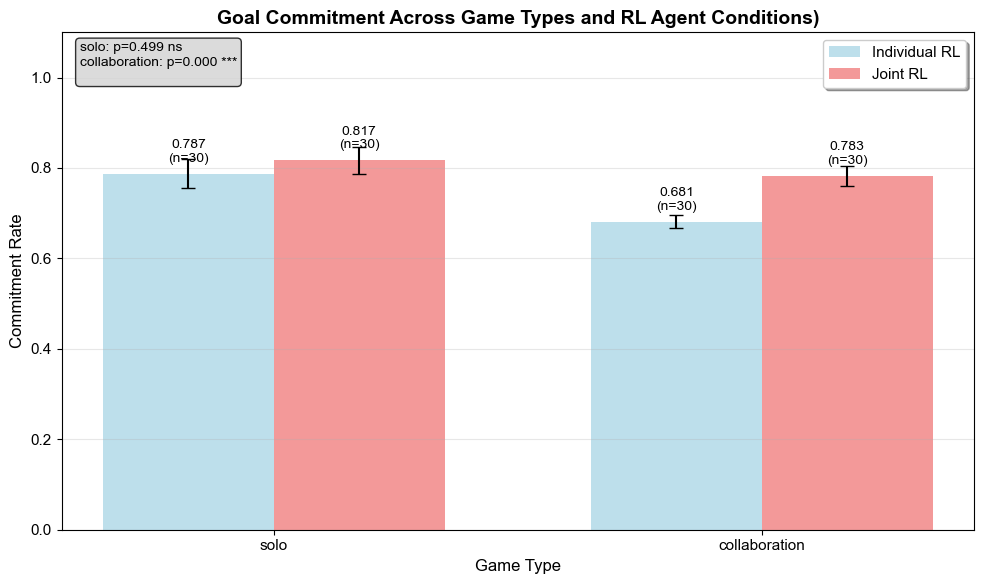


Main comparison plot (participant-level) saved as 'commitment_analysis_main_comparison_participant_level.png'


In [ ]:
# Create a focused comparison plot using participant-level data
plt.figure(figsize=(10, 6))

# Calculate means and standard errors using participant-level data
commitment_stats_participant = participant_commitment.groupby(['experiment_category', 'rlAgentType'])['commitment_rate'].agg([
    'mean', 'sem', 'count'
]).reset_index()

# Map experiment_category values for x labels
exp_label_map = {'1P2G': 'solo', '2P3G': 'collaboration'}
exp_categories = commitment_stats_participant['experiment_category'].unique()
x_labels = [exp_label_map.get(cat, cat) for cat in exp_categories]

# Create grouped bar plot
x_pos = np.arange(len(exp_categories))
width = 0.35

individual_data = commitment_stats_participant[commitment_stats_participant['rlAgentType'] == 'individual']
joint_data = commitment_stats_participant[commitment_stats_participant['rlAgentType'] == 'joint']

bars1 = plt.bar(x_pos - width/2, individual_data['mean'], width,
               yerr=individual_data['sem'], capsize=5,
               label='Individual RL', color=colors['individual'], alpha=0.8)

bars2 = plt.bar(x_pos + width/2, joint_data['mean'], width,
               yerr=joint_data['sem'], capsize=5,
               label='Joint RL', color=colors['joint'], alpha=0.8)

# Add value labels on bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    plt.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.02,
             f'{individual_data.iloc[i]["mean"]:.3f}\n(n={individual_data.iloc[i]["count"]})',
             ha='center', va='bottom', fontsize=10)
    plt.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.02,
             f'{joint_data.iloc[i]["mean"]:.3f}\n(n={joint_data.iloc[i]["count"]})',
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Game Type', fontsize=12)
plt.ylabel('Commitment Rate', fontsize=12)
plt.title('Goal Commitment Across Game Types and RL Agent Conditions)',
          fontsize=14, fontweight='bold')
plt.xticks(x_pos, x_labels)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')

# Add a text box with statistical results using participant-level data
stat_text = ""
for exp_type in exp_categories:
    exp_data = participant_commitment[participant_commitment['experiment_category'] == exp_type]
    individual_vals = exp_data[exp_data['rlAgentType'] == 'individual']['commitment_rate'].dropna()
    joint_vals = exp_data[exp_data['rlAgentType'] == 'joint']['commitment_rate'].dropna()

    if len(individual_vals) > 0 and len(joint_vals) > 0:
        t_stat, p_value = stats.ttest_ind(individual_vals, joint_vals)
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        label = exp_label_map.get(exp_type, exp_type)
        stat_text += f"{label}: p={p_value:.3f} {significance}\n"

plt.text(0.02, 0.98, stat_text, transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8),
         verticalalignment='top', fontsize=10)

plt.tight_layout()
# plt.savefig('commitment_analysis_main_comparison_participant_level.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMain comparison plot (participant-level) saved as 'commitment_analysis_main_comparison_participant_level.png'")


In [ ]:
# Save results to CSV - both trial-level and participant-level
results_summary_trial = commitment_data.groupby(['experiment_category', 'rlAgentType'])['commitment'].agg([
    'count', 'mean', 'std', 'sem'
]).round(4)

results_summary_participant = participant_commitment.groupby(['experiment_category', 'rlAgentType'])['commitment_rate'].agg([
    'count', 'mean', 'std', 'sem'
]).round(4)

# Add statistical test results using participant-level data
statistical_results = []
for exp_type in participant_commitment['experiment_category'].unique():
    exp_data = participant_commitment[participant_commitment['experiment_category'] == exp_type]
    individual_vals = exp_data[exp_data['rlAgentType'] == 'individual']['commitment_rate'].dropna()
    joint_vals = exp_data[exp_data['rlAgentType'] == 'joint']['commitment_rate'].dropna()

    if len(individual_vals) > 0 and len(joint_vals) > 0:
        t_stat, p_value = stats.ttest_ind(individual_vals, joint_vals)
        u_stat, u_p_value = stats.mannwhitneyu(individual_vals, joint_vals, alternative='two-sided')

        # Calculate Cohen's d
        pooled_std = np.sqrt(((len(individual_vals)-1)*individual_vals.var() +
                             (len(joint_vals)-1)*joint_vals.var()) /
                            (len(individual_vals) + len(joint_vals) - 2))
        cohens_d = (individual_vals.mean() - joint_vals.mean()) / pooled_std

        statistical_results.append({
            'experiment_type': exp_type,
            'individual_mean': individual_vals.mean(),
            'individual_std': individual_vals.std(),
            'joint_mean': joint_vals.mean(),
            'joint_std': joint_vals.std(),
            'difference': individual_vals.mean() - joint_vals.mean(),
            't_statistic': t_stat,
            't_test_p_value': p_value,
            'mann_whitney_u': u_stat,
            'mann_whitney_p': u_p_value,
            'cohens_d': cohens_d,
            'n_individual': len(individual_vals),
            'n_joint': len(joint_vals)
        })

statistical_df = pd.DataFrame(statistical_results)

# Save to CSV files
results_summary_trial.to_csv('commitment_analysis_summary_trial_level.csv')
results_summary_participant.to_csv('commitment_analysis_summary_participant_level.csv')
statistical_df.to_csv('commitment_analysis_statistical_tests_participant_level.csv', index=False)
participant_commitment.to_csv('commitment_analysis_participant_level_data.csv', index=False)
commitment_data[['participantID', 'experimentType', 'experiment_category', 'rlAgentType',
                'player1FirstDetectedGoal', 'player1FinalReachedGoal', 'firstDetectedSharedGoal',
                'commitment']].to_csv('commitment_analysis_detailed_trial_data.csv', index=False)

print("Results saved to:")
print("- commitment_analysis_summary_trial_level.csv (trial-level summary)")
print("- commitment_analysis_summary_participant_level.csv (participant-level summary)")
print("- commitment_analysis_statistical_tests_participant_level.csv (participant-level tests)")
print("- commitment_analysis_participant_level_data.csv (participant-level aggregated data)")
print("- commitment_analysis_detailed_trial_data.csv (individual trial data)")

print("\n=== Final Summary ===")
print(f"Total trials analyzed: {len(commitment_data)}")
print(f"Total participants: {len(participant_commitment)}")
print(f"Valid commitment scores (trials): {commitment_data['commitment'].notna().sum()}")

print("\nCommitment rates (Trial-level):")
print(results_summary_trial)

print("\nCommitment rates (Participant-level):")
print(results_summary_participant)

print("\nStatistical Tests (Participant-level):")
for _, row in statistical_df.iterrows():
    print(f"\n{row['experiment_type']}:")
    print(f"  Individual RL: {row['individual_mean']:.3f} ± {row['individual_std']:.3f} (n={row['n_individual']})")
    print(f"  Joint RL: {row['joint_mean']:.3f} ± {row['joint_std']:.3f} (n={row['n_joint']})")
    print(f"  Difference: {row['difference']:.3f}")
    print(f"  t-test: t={row['t_statistic']:.3f}, p={row['t_test_p_value']:.3f}")
    print(f"  Cohen's d: {row['cohens_d']:.3f}")


Results saved to:
- commitment_analysis_summary_trial_level.csv (trial-level summary)
- commitment_analysis_summary_participant_level.csv (participant-level summary)
- commitment_analysis_statistical_tests_participant_level.csv (participant-level tests)
- commitment_analysis_participant_level_data.csv (participant-level aggregated data)
- commitment_analysis_detailed_trial_data.csv (individual trial data)

=== Final Summary ===
Total trials analyzed: 1440
Total participants: 120
Valid commitment scores (trials): 1435

Commitment rates (Trial-level):
                                 count    mean     std     sem
experiment_category rlAgentType                               
1P2G                individual     359  0.7883  0.4091  0.0216
                    joint          360  0.8167  0.3875  0.0204
2P3G                individual     357  0.6807  0.4669  0.0247
                    joint          359  0.7827  0.4130  0.0218

Commitment rates (Participant-level):
                           

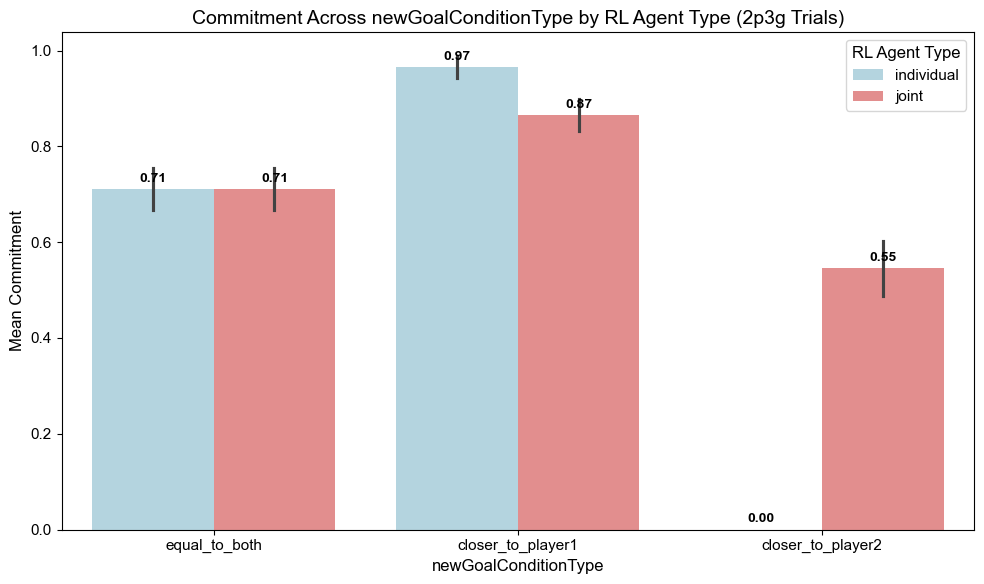

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to only 2p3g trials
data_2p3g = commitment_data[commitment_data['experimentType'] == '2P3G']

# If rlAgentType is not categorical, set order so 'individual' is left bar
if 'rlAgentType' in data_2p3g.columns:
    rl_order = ['individual', 'joint'] if set(data_2p3g['rlAgentType']) >= {'individual', 'joint'} else sorted(data_2p3g['rlAgentType'].unique())
else:
    rl_order = None

# Check if 'newGoalConditionType' exists in the filtered data
if 'newGoalConditionType' in data_2p3g.columns and not data_2p3g.empty:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=data_2p3g,
        x='newGoalConditionType',
        y='commitment',
        hue='rlAgentType',
        ci=68,
        estimator='mean',
        hue_order=rl_order
    )
    plt.title('Commitment Across newGoalConditionType by RL Agent Type (2p3g Trials)')
    plt.ylabel('Mean Commitment')
    plt.xlabel('newGoalConditionType')
    plt.legend(title='RL Agent Type')
    plt.tight_layout()

    # Use matplotlib's bar_label to get the actual bar heights and display them
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10, fontweight='bold')

    plt.show()
else:
    print("No 2p3g trials with 'newGoalConditionType' found in commitment_data.")



# RL Agent Commitment in 2P3G (Player 2)
This section analyzes the RL agent's (Player 2) commitment specifically within 2P3G trials. Commitment is defined as whether the RL agent's final reached goal matches the first detected shared goal.
- Player 2 is the RL agent in this dataset.


In [ ]:
# RL agent commitment in 2P3G (Player 2)
def calculate_rl_commitment_2p3g(row):
    shared_goal = row.get('firstDetectedSharedGoal')
    final_goal_p2 = row.get('player2FinalReachedGoal')
    if pd.isna(shared_goal) or pd.isna(final_goal_p2):
        return np.nan
    try:
        return 1 if int(shared_goal) == int(final_goal_p2) else 0
    except (ValueError, TypeError):
        return np.nan

# Filter to 2P3G trials
rl_2p3g = (df[df['experimentType'] == '2P3G'].copy()
           if 'df' in globals() else
           commitment_data[commitment_data['experimentType'] == '2P3G'].copy())

# Ensure required columns exist
missing_cols = [c for c in ['firstDetectedSharedGoal','player2FinalReachedGoal','rlAgentType'] if c not in rl_2p3g.columns]
if len(rl_2p3g) == 0 or missing_cols:
    print('Cannot compute RL agent commitment: missing data/columns:', missing_cols)
else:
    rl_2p3g['rl_agent_commitment'] = rl_2p3g.apply(calculate_rl_commitment_2p3g, axis=1)
    print(f'Computed RL agent commitment for {rl_2p3g["rl_agent_commitment"].notna().sum()} 2P3G trials')

    # Summary by RL agent type
    summary = rl_2p3g.groupby('rlAgentType')['rl_agent_commitment'].agg(['count','mean','std','sem']).round(3)
    print('
RL Agent Commitment (2P3G) by RL type:')
    print(summary)

    # Optional: by newGoalConditionType if available
    if 'newGoalConditionType' in rl_2p3g.columns:
        summary_cond = rl_2p3g.groupby(['newGoalConditionType','rlAgentType'])['rl_agent_commitment'].agg(['count','mean','std','sem']).round(3)
        print('
By newGoalConditionType:')
        print(summary_cond)

    # Plot overall by rlAgentType
    plt.figure(figsize=(8, 5))
    order = ['individual','joint'] if set(rl_2p3g['rlAgentType']) >= {'individual','joint'} else sorted(rl_2p3g['rlAgentType'].unique())
    ax = sns.barplot(data=rl_2p3g, x='rlAgentType', y='rl_agent_commitment', ci=68, estimator='mean', order=order, palette=(bar_colors if 'bar_colors' in globals() else None))
    plt.title('RL Agent (Player 2) Commitment in 2P3G')
    plt.xlabel('RL Agent Type')
    plt.ylabel('Mean Commitment')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Plot by newGoalConditionType if available
    if 'newGoalConditionType' in rl_2p3g.columns:
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(data=rl_2p3g, x='newGoalConditionType', y='rl_agent_commitment', hue='rlAgentType', ci=68, estimator='mean', hue_order=order)
        plt.title('RL Agent (Player 2) Commitment by Condition (2P3G)')
        plt.xlabel('newGoalConditionType')
        plt.ylabel('Mean Commitment')
        plt.legend(title='RL Agent Type')
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10, fontweight='bold')
        plt.tight_layout()
        plt.show()

    # Save CSV summaries
    try:
        summary.to_csv('rl_agent_2p3g_commitment_summary.csv')
        if 'newGoalConditionType' in rl_2p3g.columns:
            summary_cond.to_csv('rl_agent_2p3g_commitment_by_condition.csv')
        print('Saved: rl_agent_2p3g_commitment_summary.csv')
    except Exception as e:
        print('Save failed:', e)
